In [1]:
%matplotlib inline
import os, h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import healpy as hp
from icecream import ic

from msfm.utils import tfrecords, cosmogrid
from msfm.utils.input_output import read_yaml

In [2]:
def get_dataset(tfr_dirs, batch_size):
    dataset = tf.data.TFRecordDataset(tfr_dirs)
    dataset = dataset.map(
        tfrecords.parse_inverse_fiducial, num_parallel_calls=1, deterministic=True
    )
#     dataset = dataset.batch(batch_size, drop_remainder=False)

    return dataset

In [3]:
tfr_dir = "/cluster/scratch/athomsen/CosmoGrid/debug/fiducial"
tfr_file = "DESy3_fiducial_patches_000.tfrecord"

tfr_dirs = [os.path.join(tfr_dir, tfr_file)]

dataset = get_dataset(tfr_dirs, batch_size=1)

In [4]:
for kg, ia, sn in dataset.take(1):
    ic(kg.shape)
    ic(ia.shape)
    ic(sn.shape)

ic| kg.shape: TensorShape([13, 463872, 4])
ic| ia.shape: TensorShape([463872, 4])
ic| sn.shape: TensorShape([1, 463872, 4])


# plotting

In [5]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

pix_file = "../../data/DESY3_pixels_512.h5"
with h5py.File(pix_file, "r") as f:
    data_vec_pix = f["metacal/map_cut_outs/data_vec_ids"][:]
    non_tomo_patches_pix = f["metacal/masks/RING/non_tomo"][:]

In [6]:
meta_info_file = os.path.join("../..", conf["files"]["meta_info"])
params_info = cosmogrid.get_parameter_info(meta_info_file, "fiducial")
params_dir = [param_dir.decode("utf-8") for param_dir in params_info["path_par"]]
params_dir = [param_dir for param_dir in params_dir if not "bary" in param_dir]

In [7]:
ic(params_dir)

ic(params_dir[5])
ic(params_dir[6])

ic(params_dir[9])
ic(params_dir[10])

ic| params_dir: ['cosmo_fiducial/',
                 'cosmo_delta_H0_m/',
                 'cosmo_delta_H0_p/',
                 'cosmo_delta_Ob_m/',
                 'cosmo_delta_Ob_p/',
                 'cosmo_delta_Om_m/',
                 'cosmo_delta_Om_p/',
                 'cosmo_delta_ns_m/',
                 'cosmo_delta_ns_p/',
                 'cosmo_delta_s8_m/',
                 'cosmo_delta_s8_p/',
                 'cosmo_delta_w0_m/',
                 'cosmo_delta_w0_p/']
ic| params_dir[5]: 'cosmo_delta_Om_m/'
ic| params_dir[6]: 'cosmo_delta_Om_p/'
ic| params_dir[9]: 'cosmo_delta_s8_m/'
ic| params_dir[10]: 'cosmo_delta_s8_p/'


'cosmo_delta_s8_p/'

### OmegaM

ic| np.mean(kg_m): -0.00046380017489926846
ic| np.mean(kg_m): 0.00011933192198277993
ic| np.mean(kg_m): 0.0002266982129535832
ic| np.mean(kg_m): 0.0005448733246359091
ic| np.mean(kg_m): 0.00011305547279689896


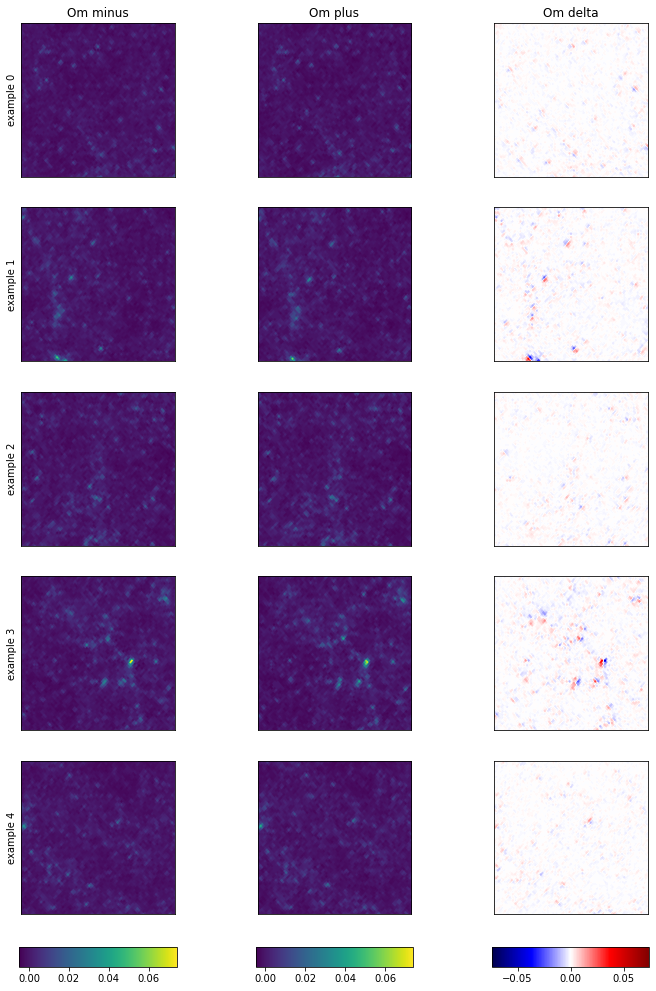

In [10]:
tomo = 0
n_examples = 5

square_pix = 1000
reso = 0.5
fig, ax = plt.subplots(figsize=(4*3, 4*n_examples), nrows=n_examples, ncols=3, sharex=True, sharey=True)

i = 0
kg_m_list = []
kg_p_list = []
kg_delta_list = []
for kg_perts, ia, sn_realz in dataset.take(n_examples):
#     ic(kg_perts.shape)
#     ic(ia.shape)
#     ic(sn_realz.shape)
    
    # only select the sigma8 perturbtions
    kg_m = kg_perts[5]
    kg_p = kg_perts[6]
    
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = kg_m[:, tomo]
    kg_m = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, return_projected_map=True, no_plot=True, xsize=square_pix, ysize=square_pix)

    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = kg_p[:, tomo]
    kg_p = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, return_projected_map=True, no_plot=True, xsize=square_pix, ysize=square_pix)

    kg_m_list.append(kg_m)
    kg_p_list.append(kg_p)
    kg_delta_list.append(kg_p - kg_m)
    
    i += 1
    
vmin = np.stack([kg_m_list, kg_p_list]).min()
vmax = np.stack([kg_m_list, kg_p_list]).max()

vtotal = np.max([np.abs(vmin), np.abs(vmax)])
vmin_delta = -vtotal
vmax_delta = vtotal

for i, (kg_m, kg_p, kg_delta) in enumerate(zip(kg_m_list, kg_p_list, kg_delta_list)):
    
    ic(np.mean(kg_m))
    
    im = ax[i, 0].imshow(kg_m, vmin=vmin, vmax=vmax)
    if i==(n_examples-1):
        fig.colorbar(im, ax=ax[:,0], orientation="horizontal", shrink=0.8, aspect=8, pad=0.03)
        
    im = ax[i, 1].imshow(kg_p, vmin=vmin, vmax=vmax)
    if i==(n_examples-1):
        fig.colorbar(im, ax=ax[:,1], orientation="horizontal", shrink=0.8, aspect=8, pad=0.03)
    
    im = ax[i, 2].imshow(kg_p-kg_m, cmap="seismic", vmin=vmin_delta, vmax=vmax_delta)
    if i==(n_examples-1):
        fig.colorbar(im, ax=ax[:,2], orientation="horizontal", shrink=0.8, aspect=8, pad=0.03)
        

    for j in range(3):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

    ax[0, 0].set(title="Om minus")
    ax[0, 1].set(title="Om plus")
    ax[0, 2].set(title="Om delta")
    ax[i,0].set(ylabel=f"example {i}")

fig.savefig(f"Om_perturbations.jpg", dpi=300, bbox_inches='tight')

### s8

ic| kg_perts.shape: TensorShape([13, 463872, 4])
ic| ia.shape: TensorShape([463872, 4])
ic| sn_realz.shape: TensorShape([1, 463872, 4])
ic| kg_perts.shape: TensorShape([13, 463872, 4])
ic| ia.shape: TensorShape([463872, 4])
ic| sn_realz.shape: TensorShape([1, 463872, 4])
ic| kg_perts.shape: TensorShape([13, 463872, 4])
ic| ia.shape: TensorShape([463872, 4])
ic| sn_realz.shape: TensorShape([1, 463872, 4])
ic| kg_perts.shape: TensorShape([13, 463872, 4])
ic| ia.shape: TensorShape([463872, 4])
ic| sn_realz.shape: TensorShape([1, 463872, 4])
ic| kg_perts.shape: TensorShape([13, 463872, 4])
ic| ia.shape: TensorShape([463872, 4])
ic| sn_realz.shape: TensorShape([1, 463872, 4])


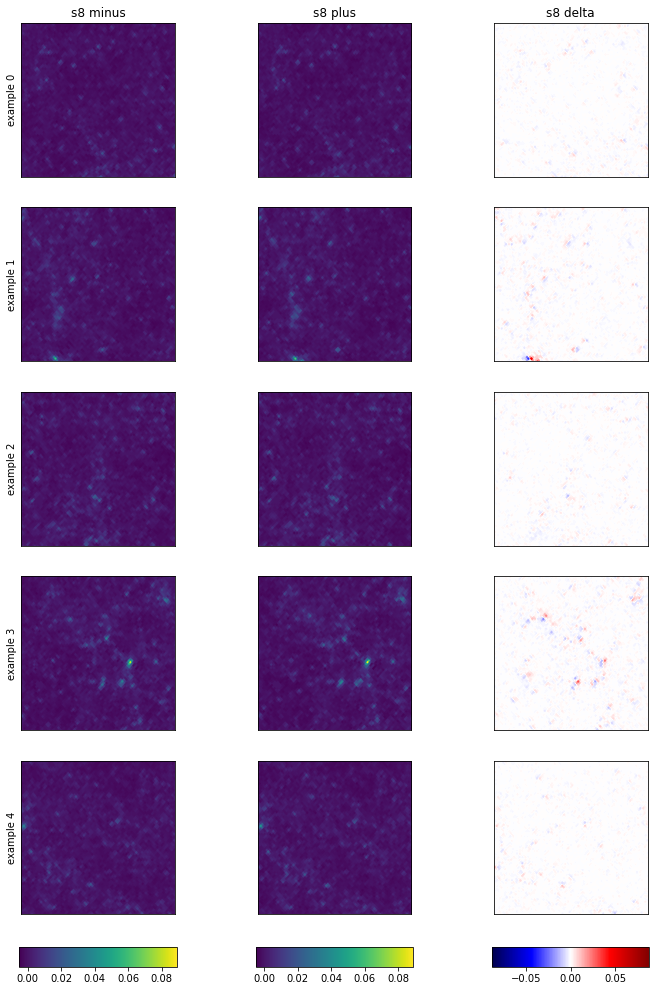

In [9]:
tomo = 0
n_examples = 5

square_pix = 1000
reso = 0.5
fig, ax = plt.subplots(figsize=(4*3, 4*n_examples), nrows=n_examples, ncols=3, sharex=True, sharey=True)

i = 0
kg_m_list = []
kg_p_list = []
kg_delta_list = []
for kg_perts, ia, sn_realz in dataset.take(n_examples):
    ic(kg_perts.shape)
    ic(ia.shape)
    ic(sn_realz.shape)
    
    # only select the sigma8 perturbtions
    kg_m = kg_perts[9]
    kg_p = kg_perts[10]
    
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = kg_m[:, tomo]
    kg_m = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, return_projected_map=True, no_plot=True, xsize=square_pix, ysize=square_pix)

    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = kg_p[:, tomo]
    kg_p = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, return_projected_map=True, no_plot=True, xsize=square_pix, ysize=square_pix)

    kg_m_list.append(kg_m)
    kg_p_list.append(kg_p)
    kg_delta_list.append(kg_p - kg_m)
    
    i += 1
    
vmin = np.stack([kg_m_list, kg_p_list]).min()
vmax = np.stack([kg_m_list, kg_p_list]).max()

vtotal = np.max([np.abs(vmin), np.abs(vmax)])
vmin_delta = -vtotal
vmax_delta = vtotal

for i, (kg_m, kg_p, kg_delta) in enumerate(zip(kg_m_list, kg_p_list, kg_delta_list)):
    
    im = ax[i, 0].imshow(kg_m, vmin=vmin, vmax=vmax)
    if i==(n_examples-1):
        fig.colorbar(im, ax=ax[:,0], orientation="horizontal", shrink=0.8, aspect=8, pad=0.03)
        
    im = ax[i, 1].imshow(kg_p, vmin=vmin, vmax=vmax)
    if i==(n_examples-1):
        fig.colorbar(im, ax=ax[:,1], orientation="horizontal", shrink=0.8, aspect=8, pad=0.03)
    
    im = ax[i, 2].imshow(kg_p-kg_m, cmap="seismic", vmin=vmin_delta, vmax=vmax_delta)
    if i==(n_examples-1):
        fig.colorbar(im, ax=ax[:,2], orientation="horizontal", shrink=0.8, aspect=8, pad=0.03)
        

    for j in range(3):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

    ax[0, 0].set(title="s8 minus")
    ax[0, 1].set(title="s8 plus")
    ax[0, 2].set(title="s8 delta")
    ax[i,0].set(ylabel=f"example {i}")

fig.savefig(f"s8_perturbations.jpg", dpi=300, bbox_inches='tight')

### perturbations

ic| kg_perts.shape: TensorShape([13, 463872, 4])
ic| ia.shape: TensorShape([463872, 4])
ic| sn_realz.shape: TensorShape([1, 463872, 4])
ic| ax.shape: (13, 3)
ic| kg_perts.shape: TensorShape([13, 463872, 4])
ic| ia.shape: TensorShape([463872, 4])
ic| sn_realz.shape: TensorShape([1, 463872, 4])
ic| ax.shape: (13, 3)
ic| kg_perts.shape: TensorShape([13, 463872, 4])
ic| ia.shape: TensorShape([463872, 4])
ic| sn_realz.shape: TensorShape([1, 463872, 4])
ic| ax.shape: (13, 3)


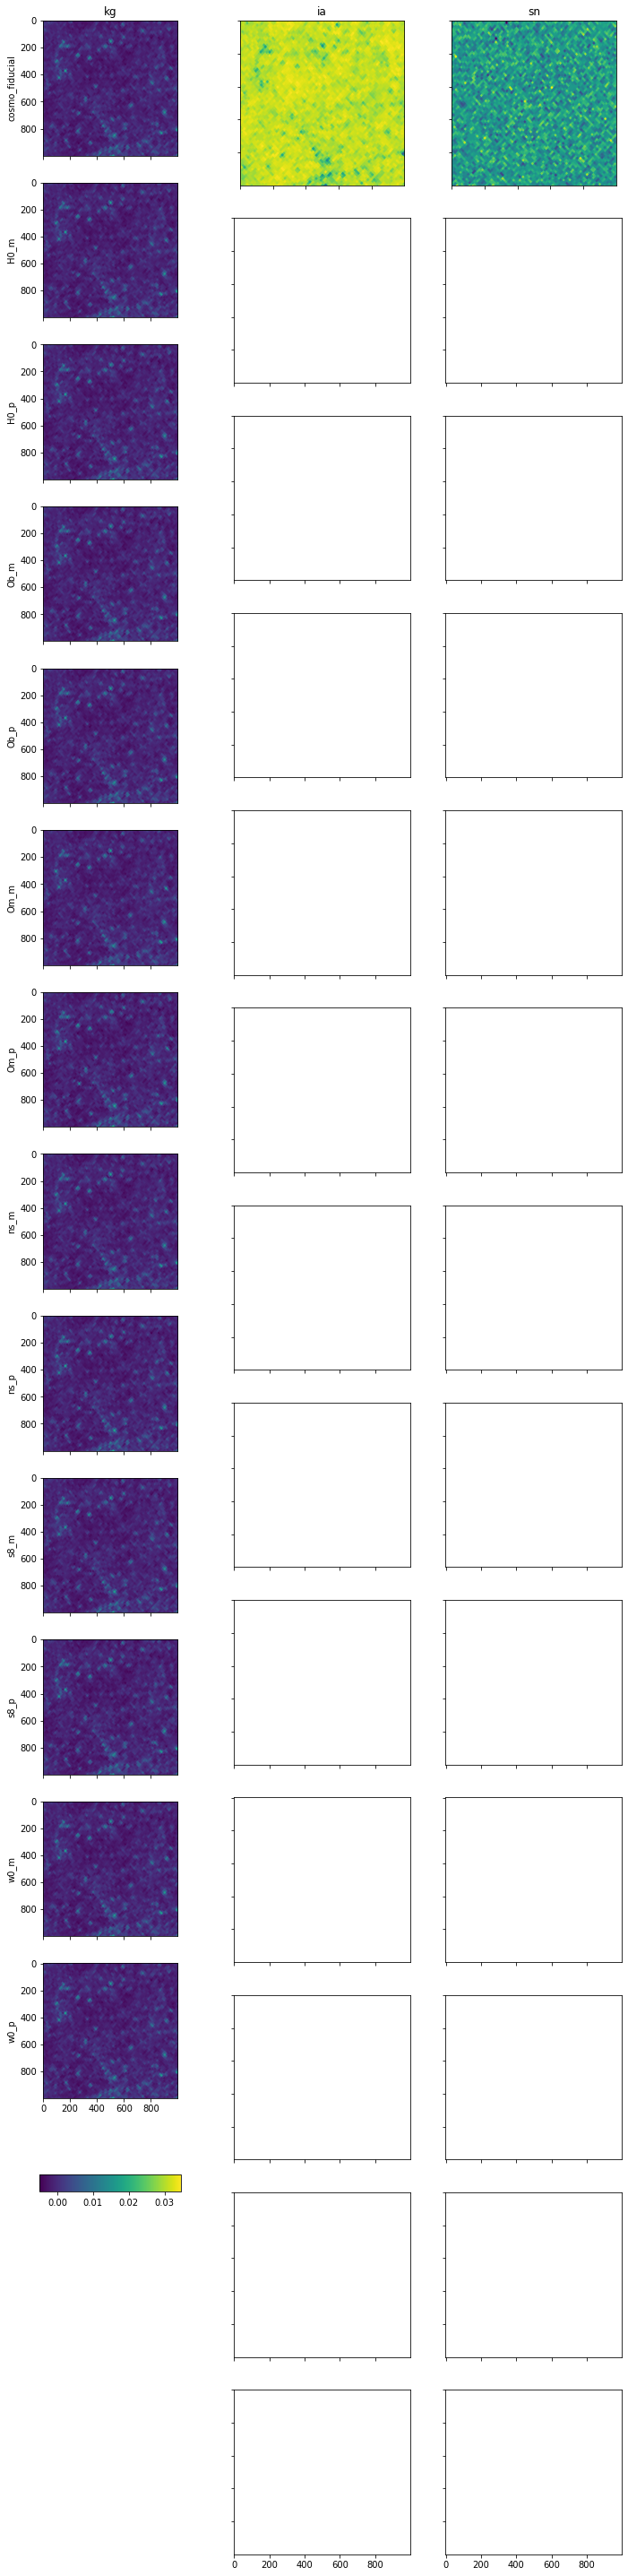

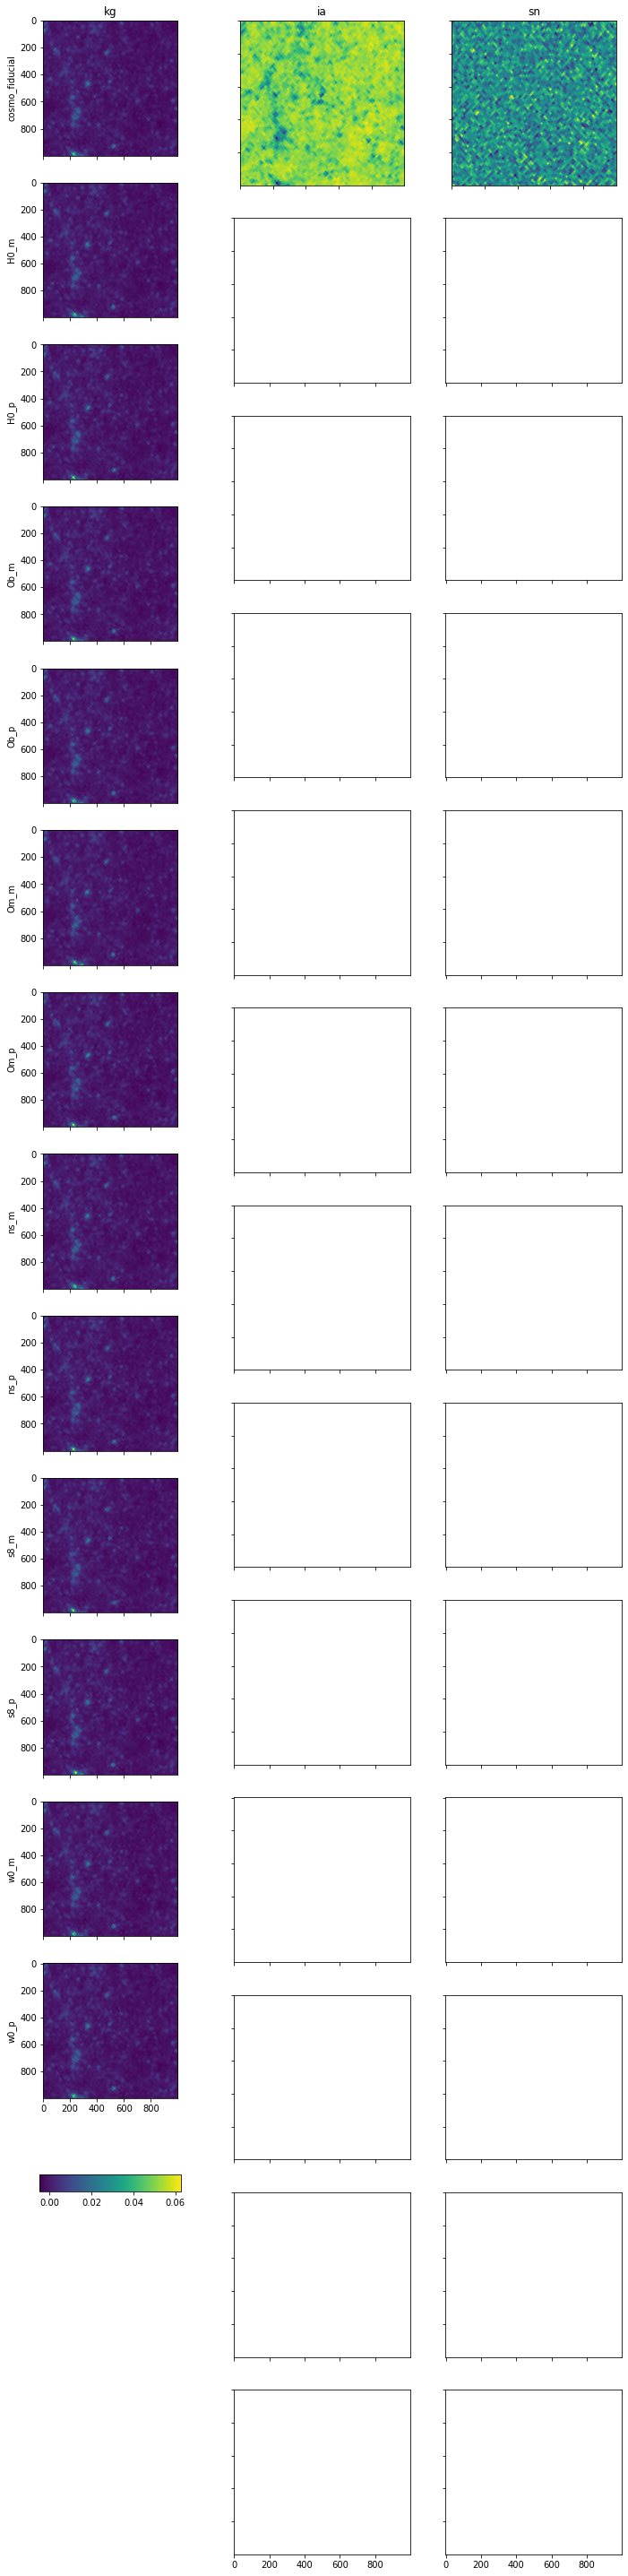

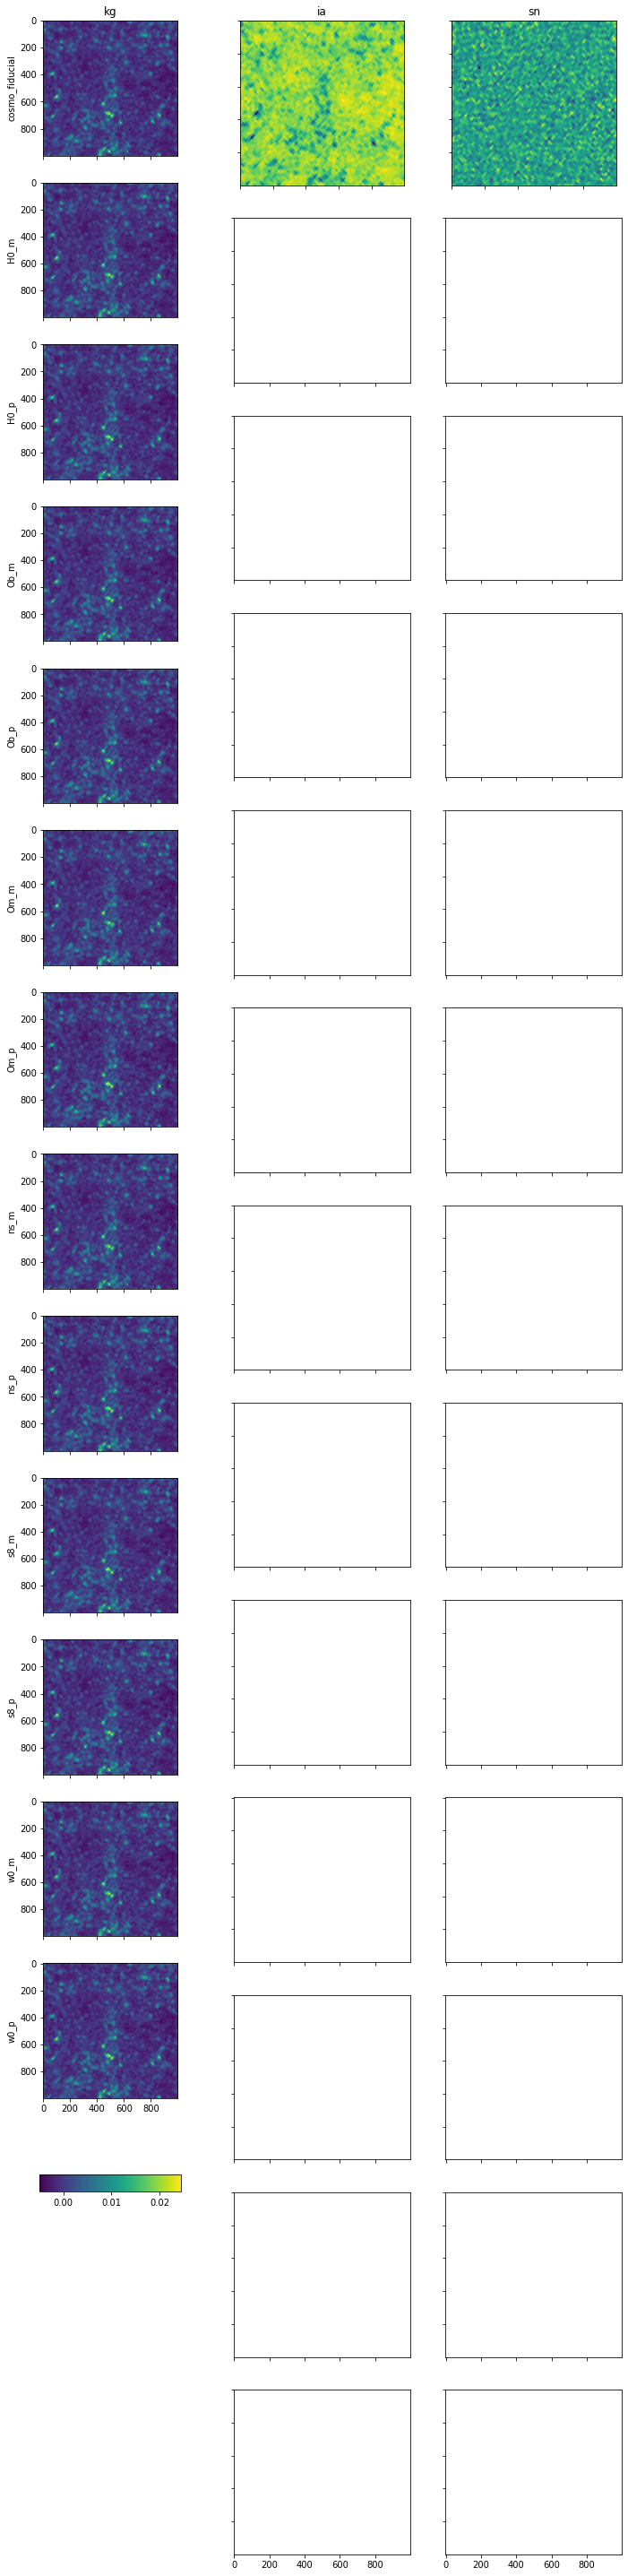

In [11]:
square_pix = 1000
reso = 0.5
tomo = 0
i_noise = 0
map_types = ["kg", "ia", "sn"]
n_types = len(map_types)

counter = 0
for kg_perts, ia, sn_realz in dataset.take(3):
    ic(kg_perts.shape)
    ic(ia.shape)
    ic(sn_realz.shape)
    
    n_perts = kg_perts.shape[0]
    
    fig, ax = plt.subplots(figsize=(4*n_types, 4*n_perts), nrows=n_perts, ncols=n_types, sharex=True, sharey=True)
    ic(ax.shape)

    # different perturbations
    kg_gnoms = []
    for kg in kg_perts:
        hp_map = np.full(n_pix, hp.UNSEEN)
        hp_map[data_vec_pix] = kg[:, tomo]

        kg_gnom = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, return_projected_map=True, no_plot=True, xsize=square_pix, ysize=square_pix)
        kg_gnoms.append(kg_gnom)
        
        vmin = np.array(kg_gnoms).min()
        vmax = np.array(kg_gnoms).max()
        for j, kg_gnom in enumerate(kg_gnoms):
            im = ax[j,0].imshow(kg_gnom, vmin=vmin, vmax=vmax)
            
            ax[j,0].set(ylabel=params_dir[j].replace("cosmo_delta_", "").replace("/", ""))
            

            if j==(n_perts-1):
                fig.colorbar(im, ax=ax[:,0], orientation="horizontal", shrink=0.8, aspect=8, pad=0.03)


        hp_map = np.full(n_pix, hp.UNSEEN)
        hp_map[data_vec_pix] = ia[:, tomo]
        ia_gnom = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, return_projected_map=True, no_plot=True, xsize=square_pix, ysize=square_pix)
        
        hp_map = np.full(n_pix, hp.UNSEEN)
        hp_map[data_vec_pix] = sn_realz[i_noise, :, tomo]
        sn_gnom = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, return_projected_map=True, no_plot=True, xsize=square_pix, ysize=square_pix)

        ax[0,1].imshow(ia_gnom)
        ax[0,2].imshow(sn_gnom)
        
        ax[0,0].set(title=map_types[0])
        ax[0,1].set(title=map_types[1])
        ax[0,2].set(title=map_types[2])


    counter += 1
                
    fig.savefig(f"fiducial_perturbations_{counter}", dpi=300, bbox_inches='tight')

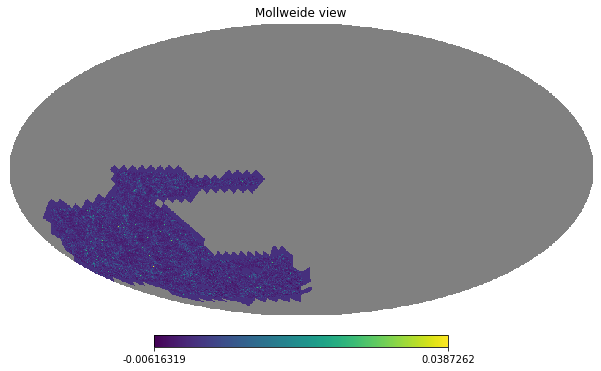

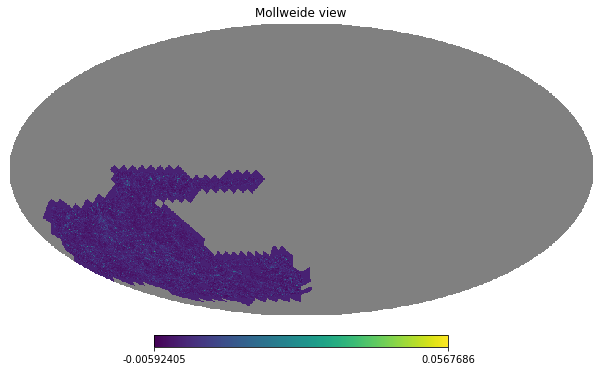

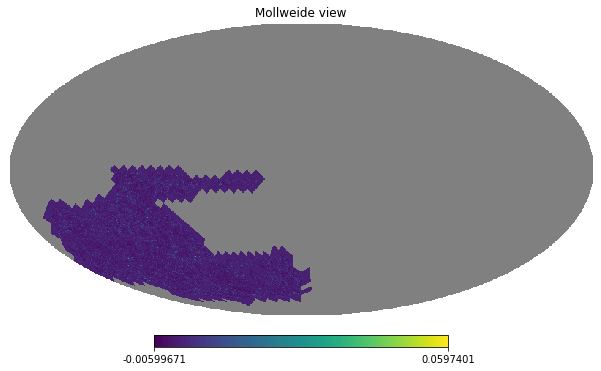

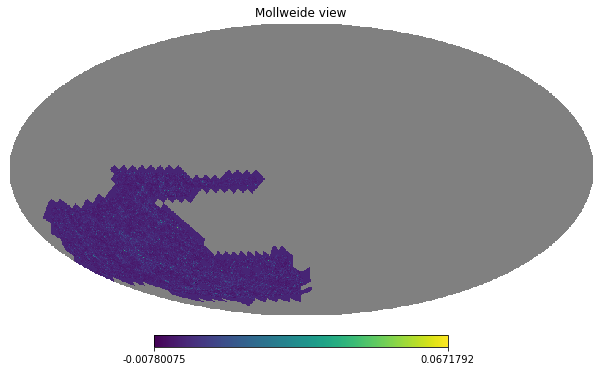

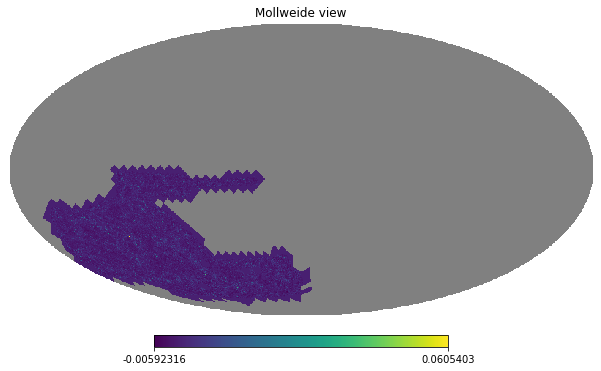

In [19]:
for kg, ia, sn in dataset.take(5):
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = kg[0,:,0]

    hp.mollview(hp_map, nest=True)